# Turbine Level Wind Forecasting with Uncertainty Quantification
---
Here we apply online (split) conformal prediction, historical quartiles and normally distributed uncertainties.  

In [89]:
import sys
from pathlib import Path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from src.models import *
from src.utils import *

import warnings
import requests

warnings.filterwarnings("ignore")

### Load Data
Our data is a mix of hourly NWP forecasts from [MeteoWeather](https://open-meteo.com/en/docs/historical-weather-api) and turbine specific features. 

In [90]:
data = pd.read_pickle("full_data_hourly.pkl")
final_data = data[[
    'Wind speed (m/s)', 'Wind direction (°)', 'Ambient temperature (converter) (°C)',
    'surface_pressure', 'Nacelle temperature (°C)', 'Rotor bearing temp (°C)', 'Vane position 1+2 (°)',
    'Blade angle (pitch position) A (°)', "wind_speed_10m", "wind_speed_80m", "wind_direction_10m",
    "wind_gusts_10m", "pressure_msl", "temperature_2m", "Power (kW)"
]].dropna()

print(f"Data shape: {final_data.shape}")
print(f"Date range: {final_data.index[0]} to {final_data.index[-1]}")
final_data.head(2)

Data shape: (7860, 15)
Date range: 2022-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00


,Wind speed (m/s),Wind direction (°),Ambient temperature (converter) (°C),surface_pressure,Nacelle temperature (°C),Rotor bearing temp (°C),Vane position 1+2 (°),Blade angle (pitch position) A (°),wind_speed_10m,wind_speed_80m,wind_direction_10m,wind_gusts_10m,pressure_msl,temperature_2m,Power (kW)
2022-01-01 00:00:00+00:00,6.781222,185.795348,14.7750,1000.1,25.2275,35.785002,-9.971973,0.0,22.8,34.1,211,49.0,1017.8,10.9,630.889598
2022-01-01 01:00:00+00:00,6.914297,194.880139,14.7975,1000.0,20.5950,35.657501,2.861364,0.0,23.7,34.4,216,50.4,1017.6,11.8,746.642319


### Prepare Features 

In [91]:
# Prepare features
target = 'Wind speed (m/s)'
df_features = create_wind_features(final_data)
df_clean = df_features.dropna()

# Define X & Y
X = df_clean.drop(columns=[target]).values
Y = df_clean[target].values

print(df_clean.columns)

Index(['Wind speed (m/s)', 'Wind direction (°)',
       'Ambient temperature (converter) (°C)', 'surface_pressure',
       'Nacelle temperature (°C)', 'Rotor bearing temp (°C)',
       'Vane position 1+2 (°)', 'Blade angle (pitch position) A (°)',
       'wind_speed_10m', 'wind_speed_80m', 'wind_direction_10m',
       'wind_gusts_10m', 'pressure_msl', 'temperature_2m', 'Power (kW)',
       'wind_cubed', 'wind_shear', 'wind_dir_sin', 'wind_dir_cos',
       'richardson_num', 'power_normalized', 'power_coeff', 'hour_sin',
       'hour_cos', 'season_sin', 'season_cos', 'wind_lag_1h', 'wind_lag_6h',
       'power_lag_1h', 'wind_trend_3h', 'power_ramp_1h', 'wind_mean_6h',
       'wind_std_6h', 'forecast_bias'],
      dtype='object')


## Uncertainty Quantification
[Rafał Weron (2025)](https://github.com/lipiecki/energy-analytics-2025/). Here we implement rolling window Split Conformal Prediction (SCP)

In [92]:
def hs(forecasts, obs, alpha):
    """
    Using historical quartiles 
    """
    errors = forecasts - obs
    return np.quantile(errors, [(1 - alpha) / 2, 1 - (1 - alpha) / 2])

def cp(forecasts, obs, alpha):
    """
    Using (split) conformal prediction
    """
    errors = np.abs(forecasts - obs)
    q = np.quantile(errors, [alpha])[0]
    return -q, q

def normal(forecasts, obs, alpha):
    """
    using normally distributed errors
    """
    errors = forecasts - obs
    mu = np.mean(errors)
    sigma = np.std(errors)
    q = norm.ppf(1 - (1 - alpha) / 2, loc=mu, scale=sigma)
    return -q, q

We use a rolling window approach, training a model daily to produce hourly forecasts for the following day. This is a common approach in industry and repersentative literature.

In [118]:
forecast_log = []

# Config
forecast_horizon = 24  # 24 hours ahead
forecast_time = 5      # Forecast hourly 24hours ahead @ 5am 
window_days = 7        # retrain on a week of data

for i in range(window_days * 24, len(df_clean) - forecast_horizon, 24):
    timestamp = df_clean.index[i]
    
    # only forecast at 5 AM
    if timestamp.hour != forecast_time:
        continue
        
    X_train = []
    Y_train = []

    for j in range(i - window_days * 24 - forecast_horizon, i - forecast_horizon):
        x = X[j]
        y = Y[j + 1 : j + 1 + forecast_horizon]
        
        if np.isnan(x).any() or np.isnan(y).any():
            continue
    
        X_train.append(x)
        Y_train.append(y)

    if np.isnan(X_train).any() or np.isnan(Y_train).any():
        continue

    # train multi-output model (OLS)
    model = MultiOutputRegressor(LinearRegression())
    model.fit(X_train, Y_train)

    # forecasted next 24 hours
    X_input = X[i].reshape(1, -1)
    Y_pred = model.predict(X_input)[0]

    # actual values & save
    Y_true = Y[i + 1:i + 1 + forecast_horizon]
    for h in range(forecast_horizon):
        forecast_log.append((df_clean.index[i + 1 + h], Y_true[h], Y_pred[h]))

# Results
forecast_df = pd.DataFrame(forecast_log, columns=["timestamp", "actual", "forecast"])
forecast_df.head()

,timestamp,actual,forecast
0,2022-04-20 06:00:00+00:00,5.156372,0.733153
1,2022-04-20 07:00:00+00:00,4.130649,2.372352
2,2022-04-20 08:00:00+00:00,4.489867,6.849809
3,2022-04-20 09:00:00+00:00,4.626394,9.000748
4,2022-04-20 10:00:00+00:00,4.588341,7.312533


In [119]:
# Compute PIs 
confidence_levels = [0.2, 0.4, 0.6, 0.8, 0.9]
calibration_hours = 36
models = ["cp", "hs", "normal"]

for alpha in confidence_levels:
    for method in models:
        forecast_df[f"lower{int(alpha * 100)}%_{method}"] = np.nan
        forecast_df[f"upper{int(alpha * 100)}%_{method}"] = np.nan

# compute intervals
for i in range(calibration_hours, len(forecast_df)):
    past_forecasts = forecast_df["forecast"].iloc[i - calibration_hours:i]
    past_obs = forecast_df["actual"].iloc[i - calibration_hours:i]

    if past_forecasts.isna().any() or past_obs.isna().any():
        continue

    y_hat = forecast_df["forecast"].iloc[i]

    for alpha in confidence_levels:
        for fn, name in zip([hs, cp, normal], ["hs", "cp", "normal"]):
            lower, upper = fn(past_forecasts.values, past_obs.values, alpha)
            forecast_df.loc[forecast_df.index[i], f"lower{int(alpha * 100)}%_{name}"] = y_hat + lower
            forecast_df.loc[forecast_df.index[i], f"upper{int(alpha * 100)}%_{name}"] = y_hat + upper

### Plot

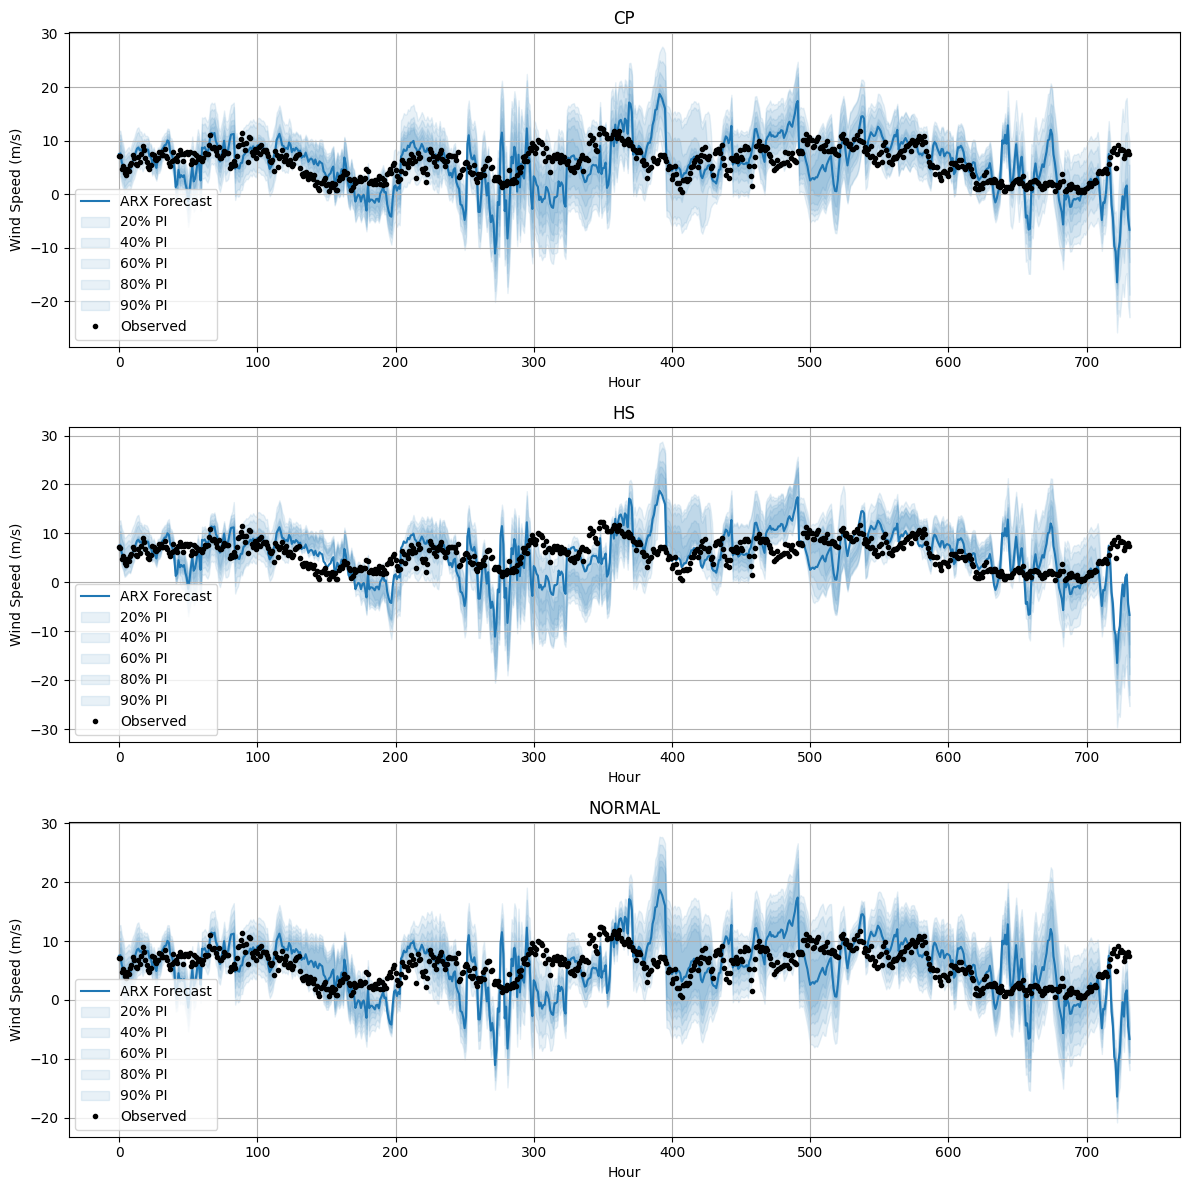

In [120]:
# collect test set PIs 
test_df = forecast_df.iloc[calibration_hours:].copy()
test_df = test_df.dropna(subset=["forecast", "actual"])
hours = np.arange(len(test_df))

# Plot
fig, axes = plt.subplots(len(models), 1, figsize=(12, 4 * len(models)))

for i, model in enumerate(models):
    ax = axes[i]
    
    # Forecast
    ax.plot(hours, test_df["forecast"], label='ARX Forecast', color='C0')

    # Prediction intervals
    for alpha in confidence_levels:
        lower = test_df[f"lower{int(alpha*100)}%_{model}"]
        upper = test_df[f"upper{int(alpha*100)}%_{model}"]
        ax.fill_between(hours, lower, upper, alpha=0.1, label=f"{int(alpha*100)}% PI", color='C0')
    
    # Actual values
    ax.plot(hours, test_df["actual"], 'o', markersize=3, label='Observed', color='black')

    # Format
    ax.set_title(model.upper())
    ax.set_xlabel("Hour")
    ax.set_ylabel("Wind Speed (m/s)")
    ax.legend(loc = "lower left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [121]:
for method in ["cp", "hs", "normal"]:
    coverage = ((forecast_df["actual"] >= forecast_df[f"lower90%_{method}"]) & 
                (forecast_df["actual"] <= forecast_df[f"upper90%_{method}"])).mean()
    print(f"{method} 90% coverage: {coverage:.3f}")

cp 90% coverage: 0.812
hs 90% coverage: 0.583
normal 90% coverage: 0.725


Violating coverage guarentees...Why? Because SCP even with rolling window assumes approximate exchangeability, which is being violated here. 